## Quick start
- Run the `pip install` cell.
- Get a free API key from [Google AI Studio](https://aistudio.google.com/app/apikey).
- Set your `GOOGLE_API_KEY` in the code below.

In [108]:
# Install dependencies
%pip install -q -U google-generativeai pillow numpy ipywidgets pandas


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Setup Gemini API
We will use the Gemini API for this notebook as Google offers a free tier for their API. However, you will need a Google Account in order to create your API key. 


## Create your API Key

Go to https://aistudio.google.com/app/apikey
Click on "Create API Key" in the top right corner

<img src="assets/img1.png" alt="Google AI Studio interface showing the Create API Key button in the top right corner of the screen with a dark blue background and navigation menu on the left side" width="800">

Next you need to name your key. Choose any name you like. 

<img src="assets/img2.png" alt="API Key naming interface" width="400">

You will also have to create a project. 

<img src="assets/img3.png" alt="Create project dialog" width="400">

Click on "Create Project" and wait for a couple of seconds until this banner appears on the top of the screen. 

<img src="assets/img4.png" alt="Project creation confirmation banner" width="400">

Now you can click on "Create Key". 

If everything went well, you should now see you new API-Key

<img src="assets/img5.png" alt="API Key display screen" width="800">

Click on the "copy" symbol (4th from right), to copy the API key to your clipboard. 

<img src="assets/img6.png" alt="Copy API key button highlighted" width="100">

Your API key should look similar to this: `AIzaDdBktb1gtk6R5HbeCHR3HRjFhrThexHFs8HT`



In [ ]:
import os
from io import StringIO
import google.generativeai as genai
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd


GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") or "PASTE_YOUR_KEY_HERE" # Paste your Google API Key here

if GOOGLE_API_KEY == "PASTE_YOUR_KEY_HERE":
    print("⚠️ Please paste your Google API Key in the variable above.")
else:
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✅ Gemini API configured")

✅ Gemini API configured


## Create a mock medical image with burnt-in PHI
We will generate a simple image that simulates a medical scan (like an X-ray or Ultrasound) with patient details burned into the pixels.

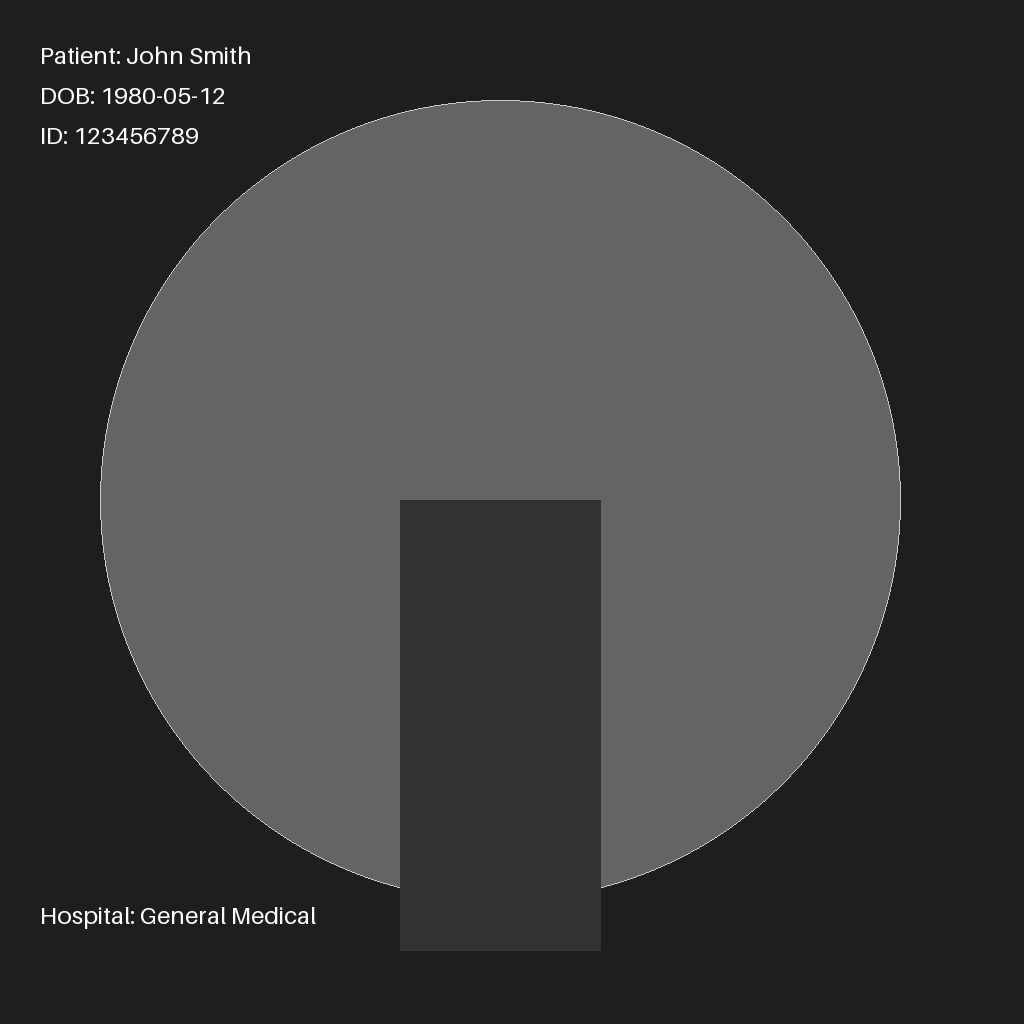

In [120]:
def create_mock_image():
    # Create a dark background (simulating X-ray background)
    img = Image.new('RGB', (1024, 1024), color = (30, 30, 30))
    d = ImageDraw.Draw(img)
    
    # Draw some "anatomy" (random shapes)
    d.ellipse([100, 100, 900, 900], fill=(100, 100, 100), outline=(200, 200, 200))
    d.rectangle([400, 500, 600, 950], fill=(50, 50, 50))
    
    # Burn in some PHI text
    # In real DICOMs, this often happens in Ultrasound or secondary captures

    text_color = (255, 255, 255)
    d.text((40, 40), "Patient: John Smith", fill=text_color, font_size=24)
    d.text((40, 80), "DOB: 1980-05-12", fill=text_color, font_size=24)
    d.text((40, 120), "ID: 123456789", fill=text_color, font_size=24)
    d.text((40, 900), "Hospital: General Medical", fill=text_color, font_size=24)
    
    return img

mock_image = create_mock_image()
display(mock_image)

## Analyze the image with Gemini Flash Lite
We will ask the model to identify any text in the image and flag potential PHI.

In [121]:
model = genai.GenerativeModel('models/gemini-flash-lite-latest')
# or, if you want to use the latest SOTA model
# But limited availability on free tier 
# model = genai.GenerativeModel('models/gemini-3-pro-preview')

prompt = """
Analyze this medical image.
1. Transcribe any text visible in the image.
2. Identify which parts of the text are Protected Health Information (PHI).
3. Provide a risk assessment (Low/Medium/High) for this image regarding patient privacy.

Return a markdown formatted tabular response that contains the following columns:
- PHI type (e.g., Name, Date of Birth, ID Number, etc.)
- Transcribed Text
- Bbox Coordinates (in format: [(x1, y1), (x2, y2)])
- Risk Level (Low/Medium/High)

format your response as a markdown table like this:
| PHI type.       | Text              | Bbox Coordinates     |  Risk Level     |
|-----------------|-------------------|----------------------|-----------------|
| [Type of PHI]   | [Transcribed Text]| [(x1, y1), (x2, y2)] | low/medium/high |

Be sure to include exact bbox coordinates with some additional padding for each detected PHI element.
"""

response = model.generate_content([prompt, mock_image])
print(response.text)

The analysis of the image for visible text and Protected Health Information (PHI) is as follows:

| PHI type | Text | Bbox Coordinates | Risk Level |
|---|---|---|---|
| Name | Patient: John Smith | [(40, 45), (215, 69)] | High |
| Date | DOB: 1980-05-12 | [(40, 79), (217, 104)] | High |
| ID Number | ID: 123456789 | [(40, 113), (206, 139)] | High |
| Facility Name | Hospital: General Medical | [(39, 882), (274, 908)] | Medium |

**Overall Risk Assessment Rationale:**

The image contains direct identifiers such as a **Name**, **Date of Birth (DOB)**, and an **ID Number**. These are considered **High Risk** PHI elements under HIPAA regulations, as they can directly identify the patient. The presence of the patient's name and DOB alone is sufficient to classify the risk as High for any exposed record containing these fields. The facility name ("Hospital: General Medical") is considered **Medium Risk** because while it is information related to healthcare, it is generally less specific th

let's further look into the response and extract the table in markdown format.

In [122]:
def extract_table_from_response(response_text):
    lines = response_text.split('\n')
    table_lines = []
    in_table = False
    for line in lines:
        if line.strip().startswith('|'):
            in_table = True
            table_lines.append(line)
        elif in_table:
            break
    return '\n'.join(table_lines)

In [127]:
def convert_markdown_table_to_dataframe(markdown_table):
    table_io = StringIO(markdown_table)
    df = pd.read_csv(table_io, sep='|', skipinitialspace=True, engine='python')
    
    # Drop empty columns created by leading/trailing pipes
    df = df.dropna(axis=1, how='all')

    # Remove the separator row (e.g., "---|---|---")
    # We check if the first row contains dashes
    if len(df) > 0 and df.iloc[0].astype(str).str.contains('---').any():
        df = df.iloc[1:]

    # Clean up whitespace in column names and data
    df.columns = df.columns.str.strip()
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    # Reset the index
    df = df.reset_index(drop=True)
    
    return df

In [128]:

table_md = extract_table_from_response(response.text)
df = convert_markdown_table_to_dataframe(table_md)
display(df)

,PHI type,Text,Bbox Coordinates,Risk Level
0,Name,Patient: John Smith,"[(40, 45), (215, 69)]",High
1,Date,DOB: 1980-05-12,"[(40, 79), (217, 104)]",High
2,ID Number,ID: 123456789,"[(40, 113), (206, 139)]",High
3,Facility Name,Hospital: General Medical,"[(39, 882), (274, 908)]",Medium
